In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
image_size = 256
batch_size = 32
channel = 3
epochs =50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato Disease Classification",
    shuffle= True,
    image_size=(image_size,image_size),
    batch_size= batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)
# total dataset = 68
# each dataset 32 images
# 68 * 32 = 2152

68

In [6]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 2 0 0 2 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 2 1 1 0 1 0]


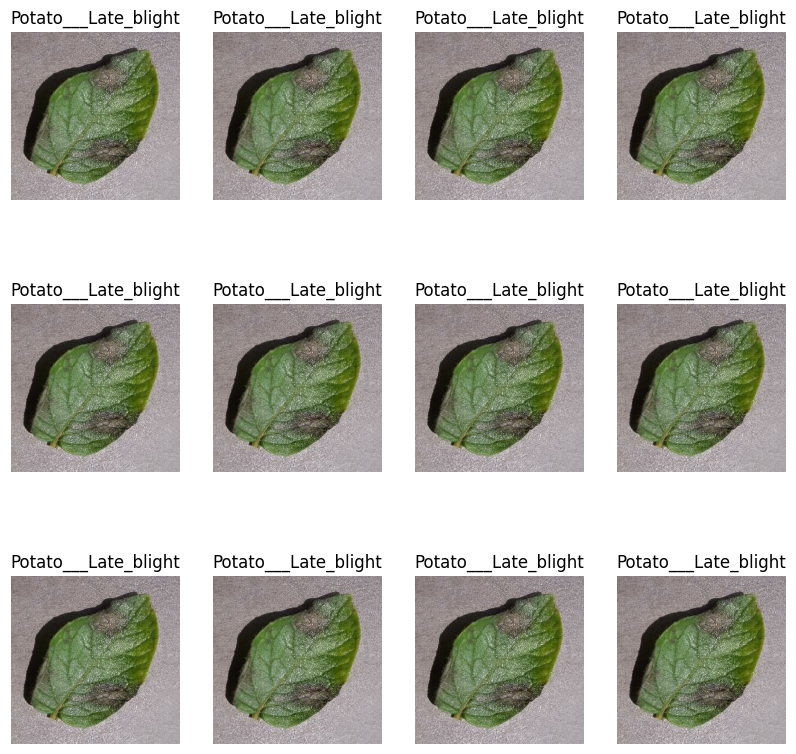

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[0]])

In [8]:
len(dataset)

68

In [9]:
#80% ==> training
#20% ==> 10% validation , 10% test

In [10]:
train_size = 0.8
len(dataset)* train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds =test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 1000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  val_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

8

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)



In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
input_shape = (batch_size,image_size, image_size,channel)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation ='relu',input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation ='relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [26]:
from keras.engine.training import optimizer
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 224s 143ms/step - loss: 0.9178 - accuracy: 0.4797 - val_loss: 0.9066 - val_accuracy: 0.4727
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.7507 - accuracy: 0.6615 - val_loss: 0.5395 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 3s 64ms/step - loss: 0.5275 - accuracy: 0.7674 - val_loss: 0.5133 - val_accuracy: 0.7578
Epoch 4/50
54/54 [==============================] - 3s 63ms/step - loss: 0.3745 - accuracy: 0.8490 - val_loss: 0.3986 - val_accuracy: 0.8516
Epoch 5/50
54/54 [==============================] - 3s 61ms/step - loss: 0.3295 - accuracy: 0.8588 - val_loss: 0.3419 - val_accuracy: 0.8672
Epoch 6/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2762 - accuracy: 0.8964 - val_loss: 0.2082 - val_accuracy: 0.9023
Epoch 7/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2163 - accuracy: 0.9115 - val_loss: 0.2446 - val_accuracy: 0.8984
Epoch 8/50

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 65ms/step - loss: 0.1041 - accuracy: 0.9655


In [29]:
scores

[0.10410904139280319, 0.9655172228813171]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
len(history.history['accuracy'])

50

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

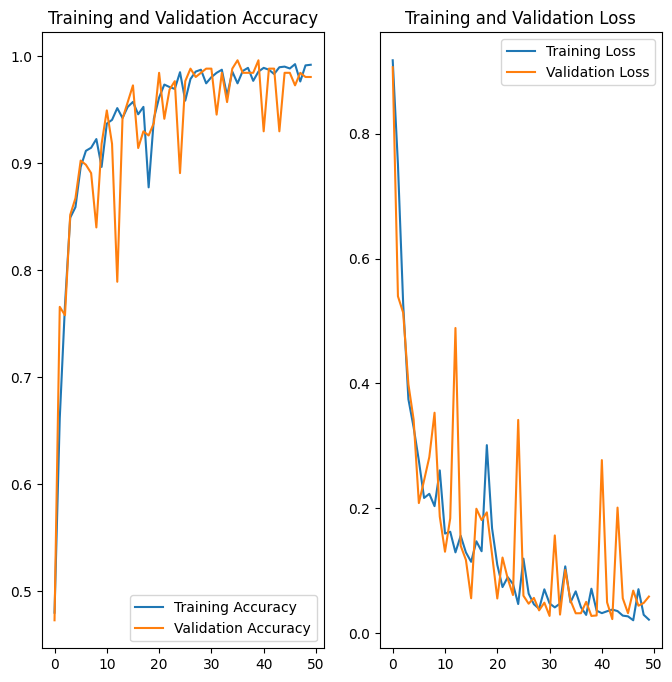

In [35]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label='Training Accuracy')
plt.plot(range(epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label='Training Loss')
plt.plot(range(epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
import numpy as np
np.argmax([1.2224457e-05, 9.9879706e-01, 1.1906868e-03])

1

first image to predict
actual label : Potato___Late_blight
1/1 [==============================] - 0s 139ms/step
predicated label :  Potato___Late_blight


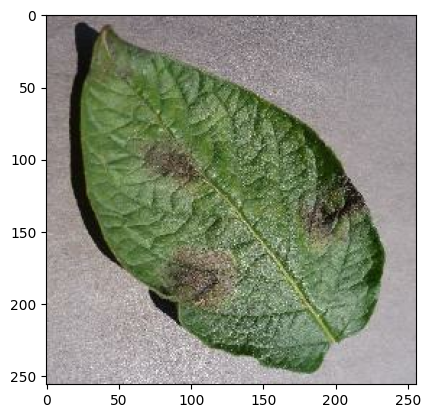

In [37]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = (images_batch[0].numpy().astype('uint8'))
  first_label = labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print('actual label :',class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print('predicated label : ',class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)# create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


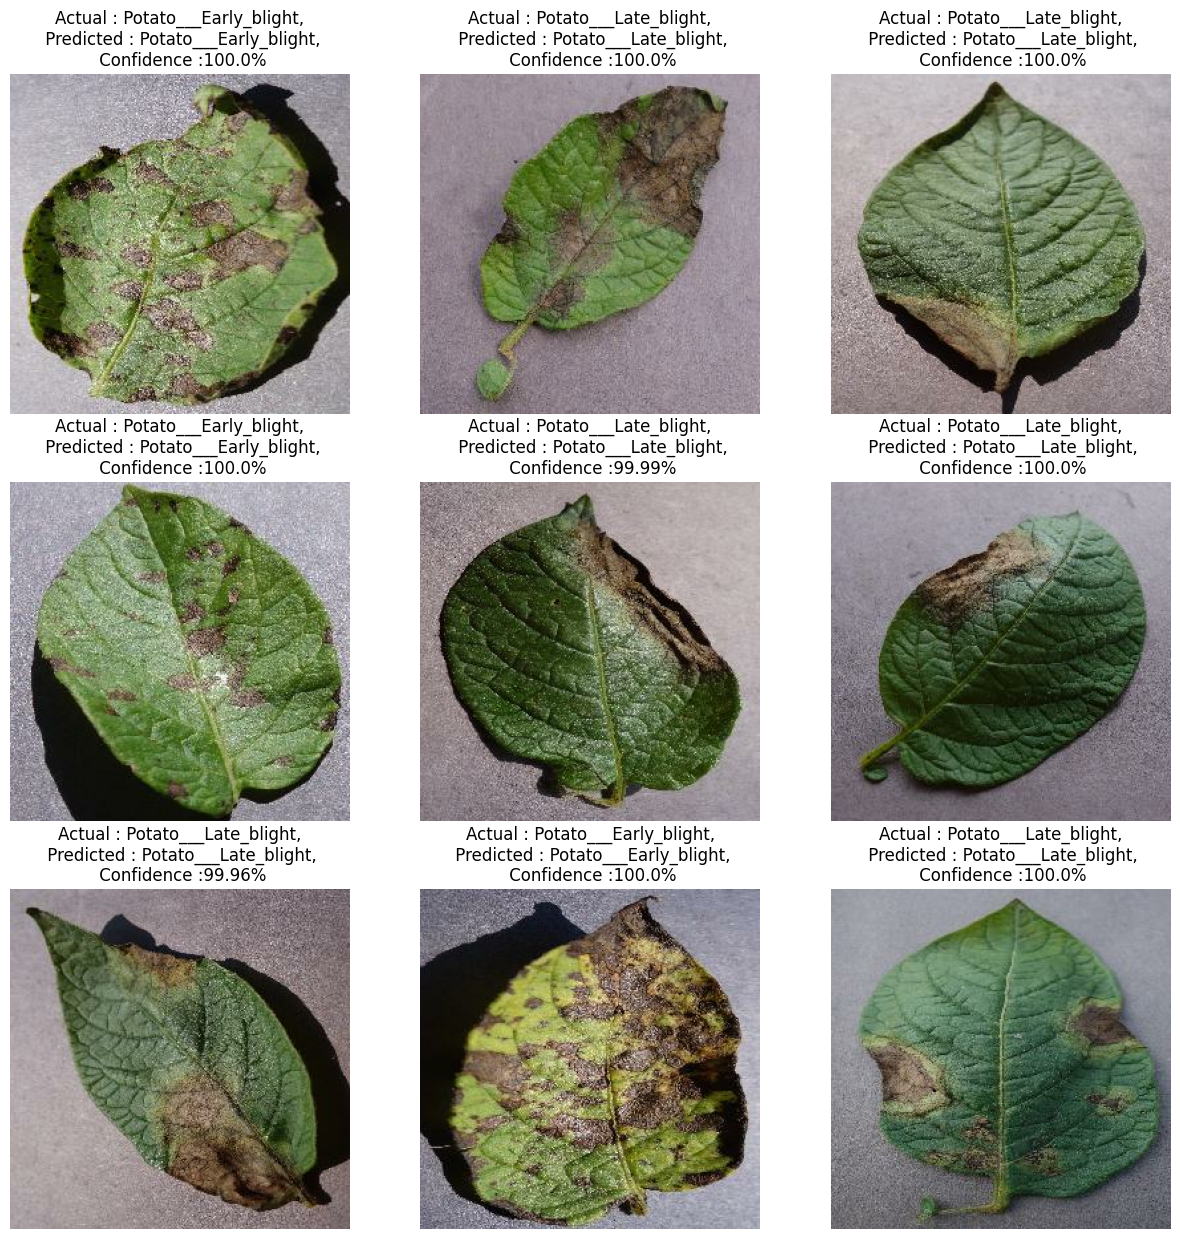

In [43]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class},\n Confidence :{confidence}%")

    plt.axis('off')

In [44]:
model_version = 1
model.save(f"/content/drive/MyDrive/Potato Disease Classification/{model_version}")